This notebook is a step by step of the perspective correction.  
It is helpful because the parameters of each step can be slightly tweaked.  
And also because you can see step by step how it all works as all as the intermediate outputs.     

Heavily inspired and modified code from  [this article and its github](https://medium.com/@siromermer/extracting-chess-square-coordinates-dynamically-with-opencv-image-processing-methods-76b933f0f64e)

In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
import  math
import csv
from PIL import Image
from pathlib import Path
import sys
import os

root_dir = os.path.dirname(os.path.abspath(''))
sys.path.append(root_dir)

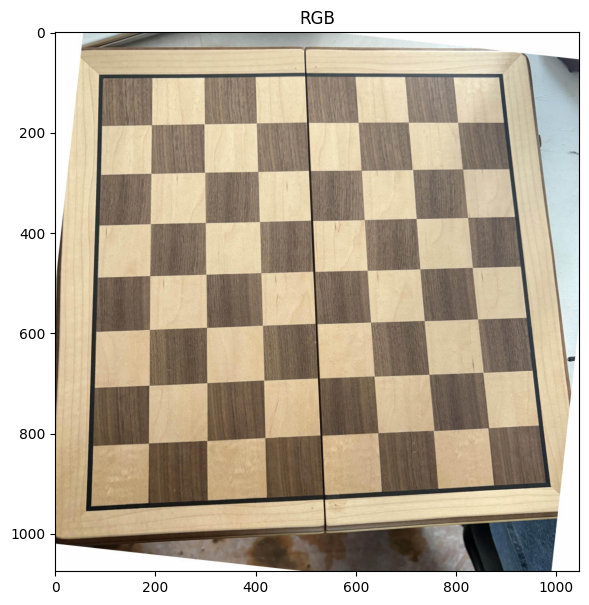

In [30]:
image_path = rf"{root_dir}/test_images/board1.jpg"

# read image and convert it to different color spaces 
image = cv2.imread(image_path)
gray_image=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
rgb_image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
 
plt.figure(figsize=(9,7))
plt.imshow(rgb_image)
plt.title("RGB");

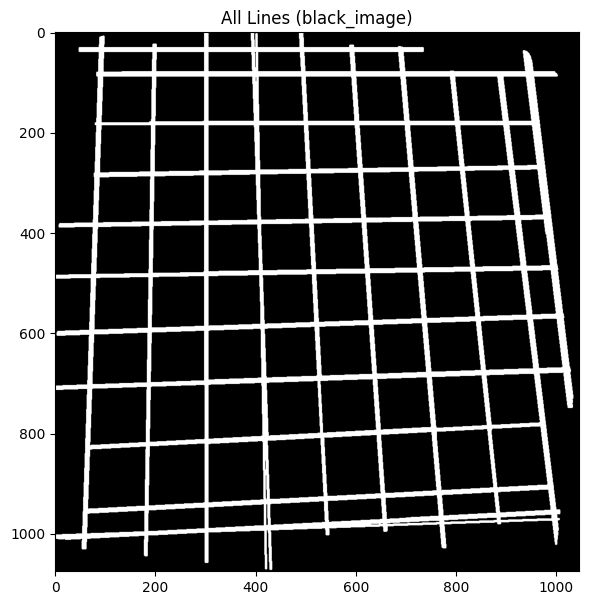

In [31]:
# OTSU threshold
ret, otsu_binary = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Canny edge detection
v = np.median(otsu_binary)
canny_image = cv2.Canny(otsu_binary, 0.66*v, 1.33*v) # type: ignore

# Dilation
kernel = np.ones((7, 7), np.uint8)
dilation_image = cv2.dilate(canny_image, kernel, iterations=1)

# Hough Lines
"""
These parameters need to be messed around with.
threshold: lower threshold = more generous with the lines
minLineLength: minimum length for a line segment to be accepted
maxLineGap: maximum allowed gap between 2 points to be considered part of the same line.
"""
lines = cv2.HoughLinesP(dilation_image, 1, np.pi / 180, threshold=500, minLineLength=150, maxLineGap=100)

# Create an image that contains only black pixels
black_image = np.zeros_like(dilation_image)

# Draw only lines that are output of HoughLinesP function to the "black_image"
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        # draw only lines to the "black_image"
        cv2.line(black_image, (x1, y1), (x2, y2), (255, 255, 255), 2)

# Dilation
kernel = np.ones((3, 3), np.uint8)
black_image = cv2.dilate(black_image, kernel, iterations=1)

plt.figure(figsize=(9,7))
plt.title("All Lines (black_image)")
plt.imshow(black_image,cmap="gray");

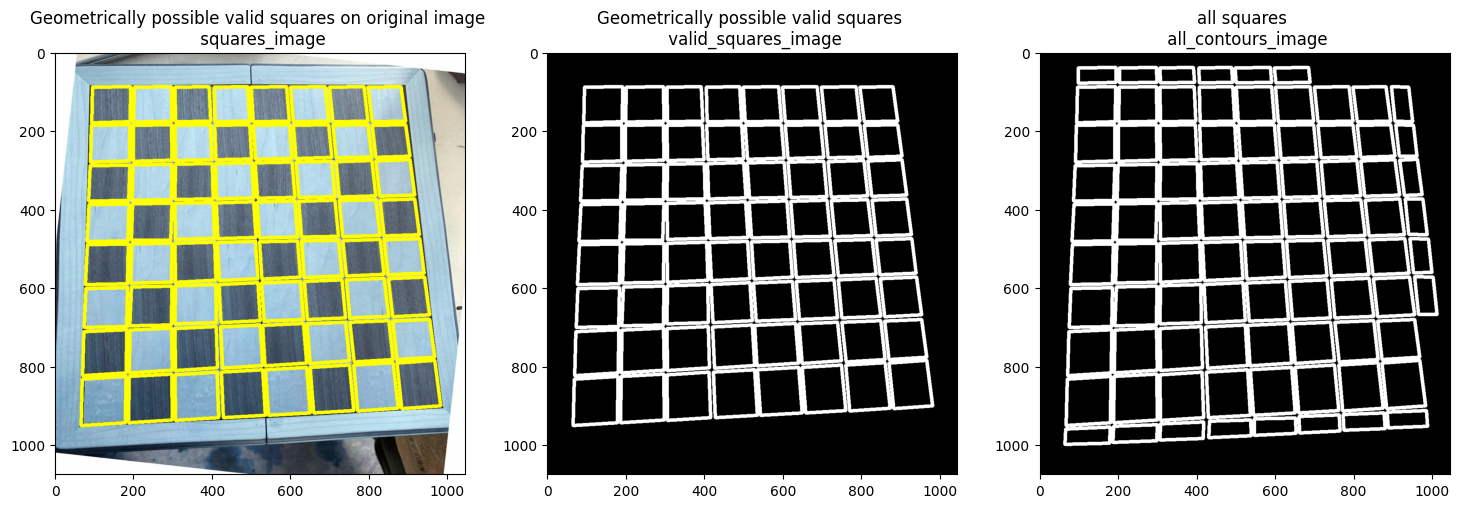

In [32]:
# Look for valid squares and check if squares are inside of board

# find contours
board_contours, hierarchy = cv2.findContours(black_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# blank image for displaying all contours
all_contours_image= np.zeros_like(black_image)

# Copy blank image for displaying all squares 
squares_image = np.copy(image) 

# blank image for displaying valid contours (squares)
valid_squares_image = np.zeros_like(black_image)

# loop through contours and filter them by deciding if they are potential squares
for contour in board_contours:
    if 2000 < cv2.contourArea(contour) < 20000:

        # Approximate the contour to a simpler shape
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        
        # if polygon has 4 vertices
        if len(approx) == 4:

            # 4 points of polygon
            pts = [pt[0].tolist() for pt in approx]

            # create same pattern for points , bottomright(1) , topright(2) , topleft(3) , bottomleft(4)
            index_sorted = sorted(pts, key=lambda x: x[0], reverse=True)

            #  Y values
            if index_sorted[0][1]< index_sorted[1][1]:
                cur=index_sorted[0]
                index_sorted[0] =  index_sorted[1]
                index_sorted[1] = cur

            if index_sorted[2][1]> index_sorted[3][1]:
                cur=index_sorted[2]
                index_sorted[2] =  index_sorted[3]
                index_sorted[3] = cur

            # bottomright(1) , topright(2) , topleft(3) , bottomleft(4)
            pt1=index_sorted[0]
            pt2=index_sorted[1]
            pt3=index_sorted[2]
            pt4=index_sorted[3]

            # find rectangle that fits 4 point 
            x, y, w, h = cv2.boundingRect(contour)
            # find center of rectangle 
            center_x=(x+(x+w))/2
            center_y=(y+(y+h))/2

            # calculate length of 4 side of rectangle
            l1 = math.sqrt((pt1[0] - pt2[0])**2 + (pt1[1] - pt2[1])**2)
            l2 = math.sqrt((pt2[0] - pt3[0])**2 + (pt2[1] - pt3[1])**2)
            l3 = math.sqrt((pt3[0] - pt4[0])**2 + (pt3[1] - pt4[1])**2)
            l4 = math.sqrt((pt1[0] - pt4[0])**2 + (pt1[1] - pt4[1])**2)
 
            # Create a list of lengths
            lengths = [l1, l2, l3, l4]
            
            # Get the maximum and minimum lengths
            max_length = max(lengths)
            min_length = min(lengths)

            # Check if this length values are suitable for a square , this threshold value plays crucial role for squares ,  
            if (max_length - min_length) <= 35: # 20 for smaller boards  , 50 for bigger , 35 works most of the time 
                valid_square=True
            else:
                valid_square=False
 
            if valid_square:

                # Draw the lines between the points
                cv2.line(squares_image, pt1, pt2, (255, 255, 0), 7)
                cv2.line(squares_image, pt2, pt3, (255, 255, 0), 7)
                cv2.line(squares_image, pt3, pt4, (255, 255, 0), 7)
                cv2.line(squares_image, pt1, pt4, (255, 255, 0), 7)

                # Draw only valid squares to "valid_squares_image"
                cv2.line(valid_squares_image, pt1, pt2, (255, 255, 0), 7)
                cv2.line(valid_squares_image, pt2, pt3, (255, 255, 0), 7)
                cv2.line(valid_squares_image, pt3, pt4, (255, 255, 0), 7)
                cv2.line(valid_squares_image, pt1, pt4, (255, 255, 0), 7)
            
            # Draw only valid squares to "valid_squares_image"
            cv2.line(all_contours_image, pt1, pt2, (255, 255, 0), 7)
            cv2.line(all_contours_image, pt2, pt3, (255, 255, 0), 7)
            cv2.line(all_contours_image, pt3, pt4, (255, 255, 0), 7)
            cv2.line(all_contours_image, pt1, pt4, (255, 255, 0), 7)
            


plt.figure(figsize=(18,15))

        
plt.subplot(131)
plt.title("Geometrically possible valid squares on original image \n squares_image")
plt.imshow(squares_image,cmap="gray")

plt.subplot(132)
plt.title("Geometrically possible valid squares \n valid_squares_image")
plt.imshow(valid_squares_image,cmap="gray")

plt.subplot(133)
plt.title("all squares \n all_contours_image")
plt.imshow(all_contours_image,cmap="gray")
 
 


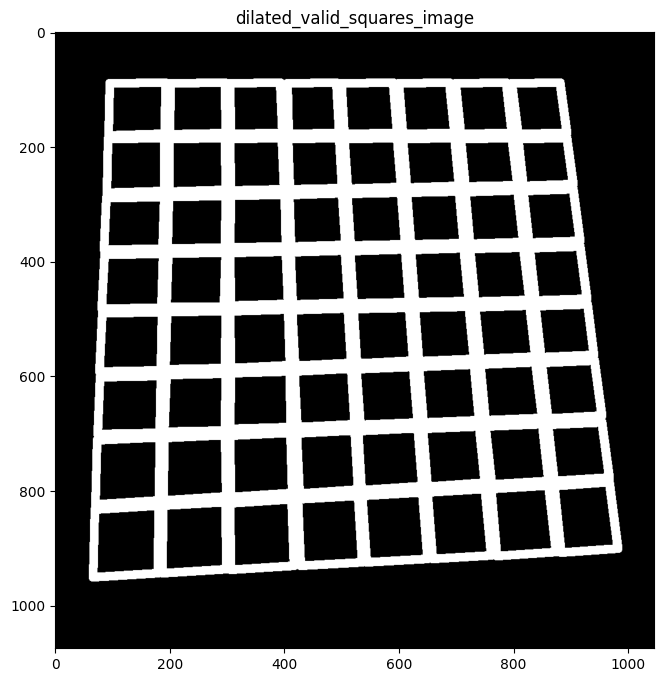

In [33]:
# Apply dilation to the valid_squares_image
kernel = np.ones((7, 7), np.uint8)
dilated_valid_squares_image = cv2.dilate(valid_squares_image, kernel, iterations=1)

plt.figure(figsize=(12,8))
plt.title("dilated_valid_squares_image")
plt.imshow(dilated_valid_squares_image,cmap="gray")

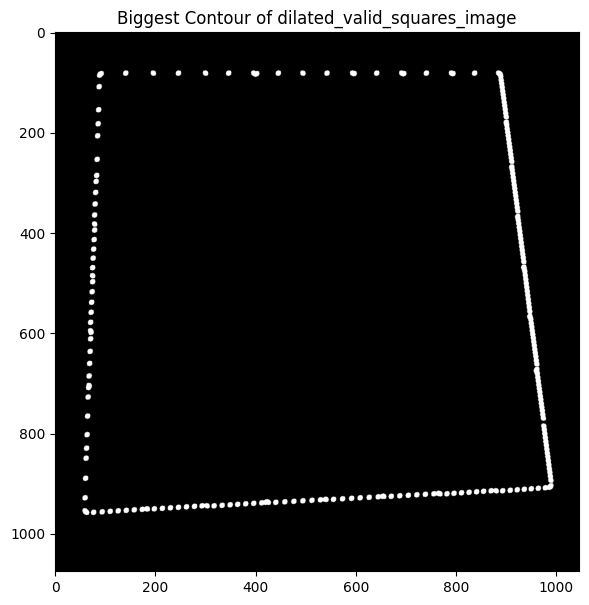

In [34]:
# Find contours of dilated_valid_squares_image
contours, _ = cv2.findContours(dilated_valid_squares_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
 
# take biggest contour 
largest_contour = max(contours, key=cv2.contourArea)

# create black image
biggest_area_image = np.zeros_like(dilated_valid_squares_image)

# draw biggest contour to the image
cv2.drawContours(biggest_area_image,largest_contour,-1,(255,255,255),10)

plt.figure(figsize=(9,7))
plt.title("Biggest Contour of dilated_valid_squares_image")
plt.imshow(biggest_area_image,cmap="gray")

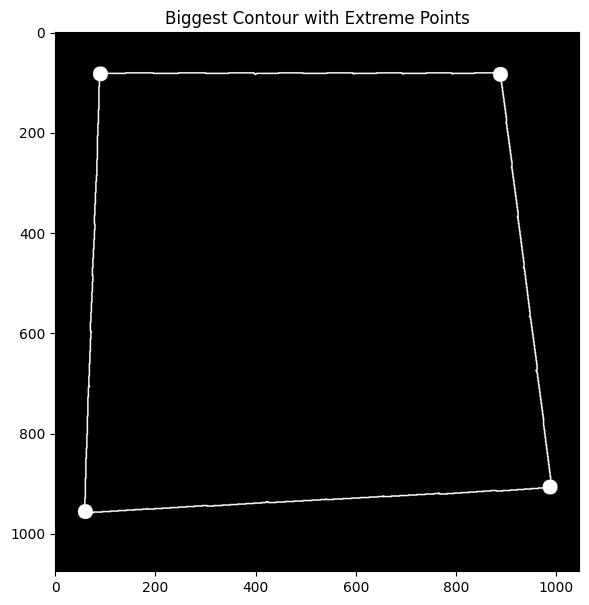

Top-left: (90, 83)
Top-right: (887, 84)
Bottom-left: (60, 956)
Bottom-right: (986, 907)


In [35]:
# Initialize variables to store extreme points
top_left = None
top_right = None
bottom_left = None
bottom_right = None

# Loop through the contour to find extreme points
for point in largest_contour[:, 0]:
    x, y = point

    if top_left is None or (x + y < top_left[0] + top_left[1]):
        top_left = (x, y)

    if top_right is None or (x - y > top_right[0] - top_right[1]):
        top_right = (x, y)

    if bottom_left is None or (x - y < bottom_left[0] - bottom_left[1]):
        bottom_left = (x, y)

    if bottom_right is None or (x + y > bottom_right[0] + bottom_right[1]):
        bottom_right = (x, y)

# Draw the contour and the extreme points
extreme_points_image = np.zeros_like(dilated_valid_squares_image, dtype=np.uint8)
cv2.drawContours(extreme_points_image, [largest_contour], -1, (255, 255, 255), thickness=2)

# Mark the extreme points
# Mark the extreme points
cv2.circle(extreme_points_image, top_left, 15, (255, 255, 255), -1)  # red for top-left
cv2.circle(extreme_points_image, top_right, 15, (255, 255, 255), -1)  # green for top-right
cv2.circle(extreme_points_image, bottom_left, 15, (255, 255,255), -1)  # blue for bottom-left
cv2.circle(extreme_points_image, bottom_right, 15, (255, 255, 255), -1)  # yellow for bottom-right


# Display the result
plt.figure(figsize=(9, 7))
plt.title("Biggest Contour with Extreme Points")
plt.imshow(extreme_points_image, cmap="gray")
plt.show()

# Print out the extreme points
print("Top-left:", top_left)
print("Top-right:", top_right)
print("Bottom-left:", bottom_left)
print("Bottom-right:", bottom_right)


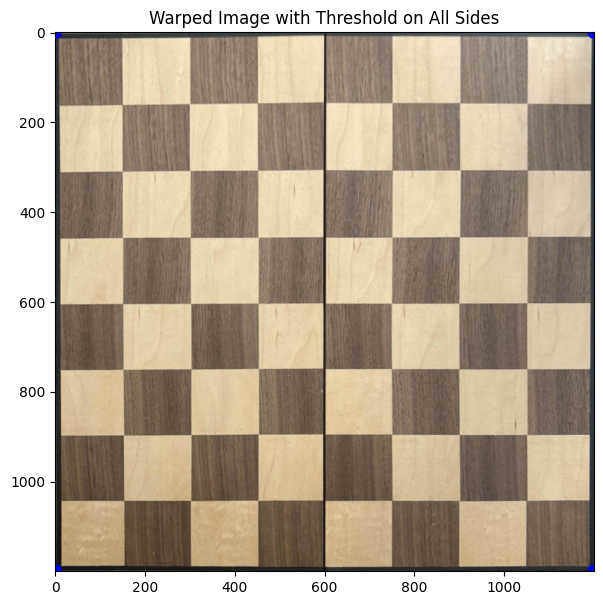

In [36]:
# Apply perspective correction

image = cv2.imread(image_path)
rgb_image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

# Define the four source points (replace with actual coordinates)
extreme_points_list = np.float32([top_left, top_right, bottom_left, bottom_right])

threshold = 0  # Extra space on all sides

width, height = 1200 , 1200 

# Define the destination points (shifted by 'threshold' on all sides)
dst_pts = np.float32([
    [threshold, threshold], 
    [width + threshold, threshold], 
    [threshold, height + threshold], 
    [width + threshold, height + threshold]
])

# Compute the perspective transform matrix
M = cv2.getPerspectiveTransform(extreme_points_list, dst_pts)

# Apply the transformation with extra width and height
warped_image = cv2.warpPerspective(rgb_image, M, (width + 2 * threshold, height + 2 * threshold))

cv2.circle(warped_image, (threshold, threshold), 15, (0, 0, 255), -1)   
cv2.circle(warped_image, (width + threshold, threshold), 15, (0, 0, 255), -1)   
cv2.circle(warped_image, (threshold, height + threshold), 15, (0, 0,255), -1)  
cv2.circle(warped_image, (width + threshold, height + threshold), 15, (0, 0, 255), -1)   

# Display the result
plt.figure(figsize=(9, 7))
plt.imshow(warped_image)
plt.title("Warped Image with Threshold on All Sides")
plt.show()


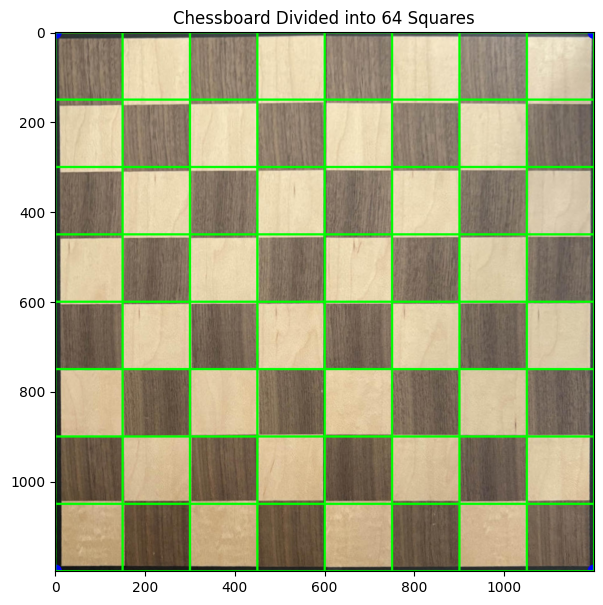

In [37]:
# Divide board into 64 squares

# Assuming area_warped is already defined
# Define number of squares (8x8 for chessboard)
rows, cols = 8, 8

# Calculate the width and height of each square
square_width = width // cols
square_height = height // rows

# Draw the squares on the warped image
for i in range(rows):
    for j in range(cols):
        # Calculate top-left and bottom-right corners of each square
        top_left = (j * square_width, i * square_height)
        bottom_right = ((j + 1) * square_width, (i + 1) * square_height)
        
        # Draw a rectangle for each square
        cv2.rectangle(warped_image, top_left, bottom_right, (0, 255, 0), 4)  # Green color, thickness 2

# Display the result
plt.figure(figsize=(9, 7))
plt.imshow(warped_image)
plt.title("Chessboard Divided into 64 Squares")
plt.show()


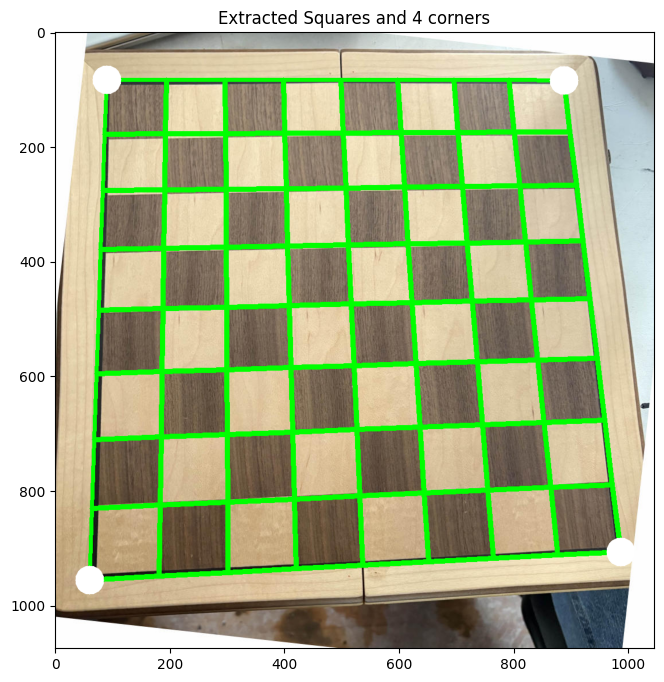

In [38]:
# inverse transformation + the add the lines  

image = cv2.imread(image_path)
rgb_image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)


# Compute the inverse perspective transformation matrix
M_inv = cv2.invert(M)[1]  # Get the inverse of the perspective matrix

rows, cols = 8, 8  # 8x8 chessboard

# Calculate the width and height of each square in the warped image
square_width = width // cols
square_height = height // rows

# List to store squares' data in the correct order (bottom-left first)
squares_data_warped = []

for i in range(rows - 1, -1, -1):  # Start from bottom row and move up
    for j in range(cols):  # Left to right order
        # Define the 4 corners of each square
        top_left = (j * square_width, i * square_height)
        top_right = ((j + 1) * square_width, i * square_height)
        bottom_left = (j * square_width, (i + 1) * square_height)
        bottom_right = ((j + 1) * square_width, (i + 1) * square_height)

        # Calculate center of the square
        x_center = (top_left[0] + bottom_right[0]) // 2
        y_center = (top_left[1] + bottom_right[1]) // 2

        # Append to list in the correct order
        squares_data_warped.append([
            (x_center, y_center),
            bottom_right,
            top_right,
            top_left,
            bottom_left
        ])

# Convert to numpy array for transformation
squares_data_warped_np = np.array(squares_data_warped, dtype=np.float32).reshape(-1, 1, 2)

# Transform all points back to the original image
squares_data_original_np = cv2.perspectiveTransform(squares_data_warped_np, M_inv)

# Reshape back to list format
squares_data_original = squares_data_original_np.reshape(-1, 5, 2)  # (num_squares, 5 points, x/y)


for square in squares_data_original:
    x_center, y_center = tuple(map(int, square[0]))  # Convert to int
    bottom_right = tuple(map(int, square[1]))
    top_right = tuple(map(int, square[2]))
    top_left = tuple(map(int, square[3]))
    bottom_left = tuple(map(int, square[4]))

    # Draw necessary lines only (to form grid)
    cv2.line(rgb_image, top_left, top_right, (0, 255, 0), 6)  # Top line
    cv2.line(rgb_image, top_left, bottom_left, (0, 255, 0), 6)  # Left line

    # Draw bottom and right lines only for last row/column
    if j == cols - 1:
        cv2.line(rgb_image, top_right, bottom_right, (0, 255, 0), 8)  # Right line
    if i == 0:
        cv2.line(rgb_image, bottom_left, bottom_right, (0, 255, 0), 8)  # Bottom line

cv2.circle(rgb_image, (int(extreme_points_list[0][0]),int(extreme_points_list[0][1])), 25, (255, 255, 255), -1)   
cv2.circle(rgb_image,  (int(extreme_points_list[1][0]),int(extreme_points_list[1][1])), 25, (255, 255, 255), -1)   
cv2.circle(rgb_image,  (int(extreme_points_list[2][0]),int(extreme_points_list[2][1])), 25, (255, 255,255), -1)   
cv2.circle(rgb_image,  (int(extreme_points_list[3][0]),int(extreme_points_list[3][1])), 25, (255, 255, 255), -1)   

# Display the result
plt.figure(figsize=(12, 8))
plt.imshow(rgb_image)
plt.title("Extracted Squares and 4 corners")
plt.show()

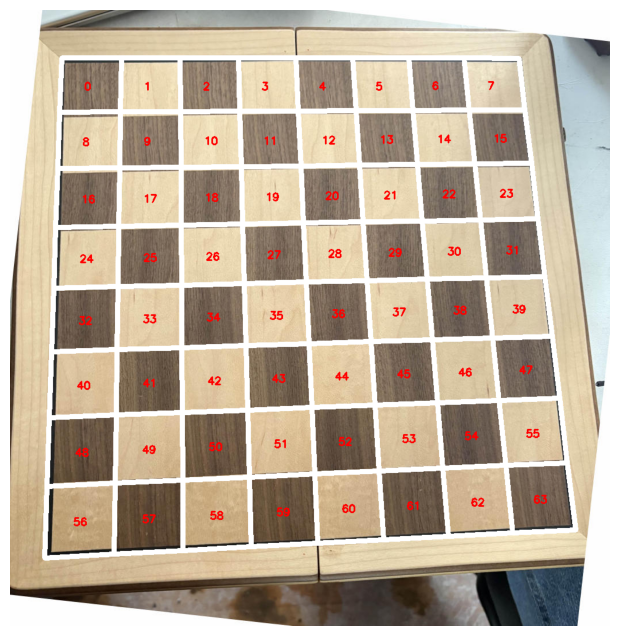

In [39]:
# Clean up squares data structure a bit and display it all.

squares = [
    {
        "center": center,
        "corners": [bottom_right, top_right, top_left, bottom_left]
    }
    for center, bottom_right, top_right, top_left, bottom_left in squares_data_original
]

# Sort by Y (top → bottom)
squares_sorted = sorted(squares, key=lambda s: s["center"][1])

# Split into 8 rows
rows = np.array_split(squares_sorted, 8) # type: ignore

# Sort each row by X (left → right)
rows = [sorted(row, key=lambda s: s["center"][0]) for row in rows]

label = 0
for row in rows:
    for sq in row:
        sq["id"] = label
        label += 1

"""
Now each square looks like:
{
  "id": 17,
  "center": (x, y),
  "corners": [...]
}

"""

for sq in squares:
    pts = np.array(sq["corners"], dtype=np.int32).reshape((-1,1,2))
    cv2.polylines(image, [pts], True, (255,255,255), 8)

    cx, cy = sq["center"]
    cv2.putText(
        image,
        str(sq["id"]),
        (int(cx - 12), int(cy + 10)),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.6,
        (0, 0, 255),
        2
    )

# Display
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()
